Objective of this task is to predict SP500, here is the break down of the structure of this notebook.
1. Data collection (SP500 historical data)
2. Measure daily momentum (open-close) and daily volatility (high-low)
3. Target variable: +1 for price increase and 0 for no flat close or decrease
4. Train-test split 80/20
5. Model training,SVM and kernel (Gaussian RBF) and model evaluation
6. Hyperparamters tuning using randomized search CV
7. Appendix


# 1. Data collection

In [1]:
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [52]:
import yfinance as yf
import pandas as pd

ticker = '^GSPC'
start_date = '2020-10-01'
end_date = '2025-10-01'

sp500 = yf.download(ticker, start=start_date, end=end_date)
print(sp500.head())

/tmp/ipython-input-1939083225.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2020-10-01  3380.800049  3397.179932  3361.389893  3385.870117  4076340000
2020-10-02  3348.419922  3369.100098  3323.689941  3338.939941  3975180000
2020-10-05  3408.600098  3409.570068  3367.270020  3367.270020  3692720000
2020-10-06  3360.969971  3431.560059  3354.540039  3408.739990  4453390000
2020-10-07  3419.439941  3426.260010  3384.560059  3384.560059  3814750000


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-10-01,3380.800049,3397.179932,3361.389893,3385.870117,4076340000
2020-10-02,3348.419922,3369.100098,3323.689941,3338.939941,3975180000
2020-10-05,3408.600098,3409.570068,3367.270020,3367.270020,3692720000
2020-10-06,3360.969971,3431.560059,3354.540039,3408.739990,4453390000
2020-10-07,3419.439941,3426.260010,3384.560059,3384.560059,3814750000


In [56]:

sp500.columns = [col[0] if isinstance(col, tuple) else col for col in sp500.columns]
sp500.columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [4]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4c35ae3a11e6f2c879d07235913b87db1e3192341551cf320428977d49677179
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [57]:

print(type(sp500['Close']))
print(sp500['Close'].shape)

<class 'pandas.core.series.Series'>
(1255,)


In [58]:
import ta
from ta.momentum import RSIIndicator

sp500.dropna(inplace=True)

# Add RSI (Relative Strength Index)
close_series = sp500['Close'].squeeze()
rsi_indicator = ta.momentum.RSIIndicator(close=sp500['Close'].squeeze(), window=14)
sp500['RSI'] = rsi_indicator.rsi()


In [59]:
sp500.tail()

,Close,High,Low,Open,Volume,RSI
Date,,,,,,
2025-09-24,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,64.144695
2025-09-25,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,58.655778
2025-09-26,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,62.686866
2025-09-29,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,64.367515
2025-09-30,6688.459961,6691.250000,6641.000000,6656.189941,6057210000,66.868586


In [60]:
from ta.trend import MACD
# Add MACD (Moving Average Convergence Divergence)
close_series = pd.Series(sp500['Close'].values.flatten(), index=sp500.index)
macd = MACD(close=close_series)
sp500['MACD'] = macd.macd()
sp500['MACD_Signal'] = macd.macd_signal()
sp500['MACD_Diff'] = macd.macd_diff()

In [61]:
sp500.tail()

,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,MACD_Diff
Date,,,,,,,,,
2025-09-24,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,64.144695,67.583744,62.763311,4.820433
2025-09-25,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,58.655778,62.201272,62.650903,-0.449632
2025-09-26,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,62.686866,60.384902,62.197703,-1.812801
2025-09-29,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,64.367515,59.670464,61.692255,-2.021791
2025-09-30,6688.459961,6691.250000,6641.000000,6656.189941,6057210000,66.868586,60.604504,61.474705,-0.870201


# 2. Momentum and Volatility

Daily momentum of stock price and Daily volatility of stock price (not of daily return)

In [62]:
# Daily momentum and volatility
sp500['Daily_Momentum'] = sp500['Close'] - sp500['Open']
sp500['Normalized_Momentum'] = sp500['Daily_Momentum'] / sp500['Open']

sp500['Daily_Volatility'] = sp500['High'] - sp500['Low']
sp500['Normalized_Volatility'] = sp500['Daily_Volatility'] / sp500['Open']

In [64]:
sp500.tail()

,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,MACD_Diff,Daily_Momentum,Normalized_Momentum,Daily_Volatility,Normalized_Volatility
Date,,,,,,,,,,,,,
2025-09-24,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,64.144695,67.583744,62.763311,4.820433,-31.819824,-0.004771,50.900391,0.007631
2025-09-25,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,58.655778,62.201272,62.650903,-0.449632,-3.469727,-0.000525,49.779785,0.007533
2025-09-26,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,62.686866,60.384902,62.197703,-1.812801,28.320312,0.004281,44.540039,0.006733
2025-09-29,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,64.367515,59.670464,61.692255,-2.021791,-0.370117,-0.000056,32.819824,0.004927
2025-09-30,6688.459961,6691.250000,6641.000000,6656.189941,6057210000,66.868586,60.604504,61.474705,-0.870201,32.270020,0.004848,50.250000,0.007549


# 3. Target Variable

In [65]:
# Shift close price to get next day's close
sp500['Next_Close'] = sp500['Close'].shift(-1)

# Define target: +1 if price increases, else 0
sp500['Target'] = (sp500['Next_Close'] > sp500['Close']).astype(int)

In [66]:
sp500.tail()

,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,MACD_Diff,Daily_Momentum,Normalized_Momentum,Daily_Volatility,Normalized_Volatility,Next_Close,Target
Date,,,,,,,,,,,,,,,
2025-09-24,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,64.144695,67.583744,62.763311,4.820433,-31.819824,-0.004771,50.900391,0.007631,6604.720215,0
2025-09-25,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,58.655778,62.201272,62.650903,-0.449632,-3.469727,-0.000525,49.779785,0.007533,6643.700195,1
2025-09-26,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,62.686866,60.384902,62.197703,-1.812801,28.320312,0.004281,44.540039,0.006733,6661.209961,1
2025-09-29,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,64.367515,59.670464,61.692255,-2.021791,-0.370117,-0.000056,32.819824,0.004927,6688.459961,1
2025-09-30,6688.459961,6691.250000,6641.000000,6656.189941,6057210000,66.868586,60.604504,61.474705,-0.870201,32.270020,0.004848,50.250000,0.007549,NaN,0


In [68]:
## feature selection and setting target variable

features = [
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff',
    'Normalized_Momentum', 'Normalized_Volatility'
]
X = sp500[features]
y = sp500['Target']

X = X.dropna()
y = y.loc[X.index]  # matches with X

# 4. Test/Train dataset

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [70]:
# Example: 250-day rolling window
window_size = 250
for start in range(0, len(X) - window_size):
    X_window = X[start:start+window_size]
    y_window = y[start:start+window_size]


In [71]:
X_window

,RSI,MACD,MACD_Signal,MACD_Diff,Normalized_Momentum,Normalized_Volatility
Date,,,,,,
2024-09-30,66.319659,61.050963,50.151941,10.899022,0.006280,0.010759
2024-10-01,58.546489,57.646093,51.650771,5.995321,-0.008507,0.013278
2024-10-02,58.623284,54.384546,52.197526,2.187020,0.002001,0.008008
2024-10-03,57.235741,50.443617,51.846745,-1.403128,0.000307,0.007267
2024-10-04,62.347328,50.859876,51.649371,-0.789495,0.002369,0.008781
...,...,...,...,...,...,...
2025-09-23,67.486806,70.085246,61.558203,8.527043,-0.005307,0.008060
2025-09-24,64.144695,67.583744,62.763311,4.820433,-0.004771,0.007631
2025-09-25,58.655778,62.201272,62.650903,-0.449632,-0.000525,0.007533


# 5. Model training and evaluation

In [72]:
# Initialize SVM with RBF kernel (good for nonlinear separation), assuming the hyperparameters , C=1.0, gamma=0.1 and setting kernel = RBF. We will tune C and gamma in later sections
svm_model = SVC(kernel='rbf', C=1.0, gamma=0.1, probability=True, random_state=42)

In [73]:
svm_model.fit(X_train, y_train)

SVC(gamma=0.1, probability=True, random_state=42)

In [74]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = svm_model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5020408163265306
Classification Report:
               precision    recall  f1-score   support

           0       0.36      0.19      0.25       107
           1       0.54      0.75      0.63       138

    accuracy                           0.50       245
   macro avg       0.45      0.47      0.44       245
weighted avg       0.46      0.50      0.46       245

Confusion Matrix:
 [[ 20  87]
 [ 35 103]]


Accuracy is 50.204% which is barely better than random guess and precision of 0.36 shows model is not able to discriminate

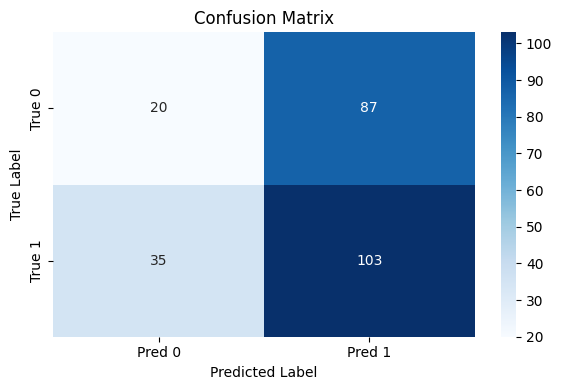

In [80]:
#Visulasation of confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


# 6. Hyperparameters

In [76]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist = {
    'C': uniform(0.1, 10),         # samples C from 0.1 to 10
    'gamma': uniform(0.001, 1),    # samples gamma from 0.001 to 1
    'kernel': ['rbf']
}

search = RandomizedSearchCV(SVC(class_weight='balanced'), param_distributions=param_dist, n_iter=20, cv=5)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a8a3ccdb320>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7a8a3c63cec0>,
                                        'kernel': ['rbf']})

In [77]:
results_df = pd.DataFrame(search.cv_results_)

# Show key columns
print(results_df[['param_C', 'param_gamma', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False))

     param_C  param_gamma  mean_test_score
6   0.785825     0.862439         0.520994
1   4.807196     0.662635         0.520989
0   8.848452     0.755745         0.519979
4   9.760666     0.741438         0.518953
7   9.681239     0.823058         0.516902
17  1.622487     0.950048         0.515877
12  4.809291     0.915431         0.514851
9   5.055006     0.896107         0.514851
5   1.636731     0.906260         0.513830
2   3.825007     0.520957         0.511763
13  4.401895     0.519160         0.511763
14  8.083117     0.500290         0.510743
15  8.914995     0.463912         0.509723
18  4.890048     0.411519         0.506667
16  9.946382     0.307765         0.504605
3   3.966612     0.319505         0.503590
11  9.070998     0.302360         0.503590
8   9.257317     0.326264         0.503585
10  9.976976     0.214819         0.497446
19  8.031088     0.172590         0.492344


In [78]:
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)

Best parameters: {'C': np.float64(0.7858251017586669), 'gamma': np.float64(0.8624390725756331), 'kernel': 'rbf'}
Best CV score: 0.5209942438513867


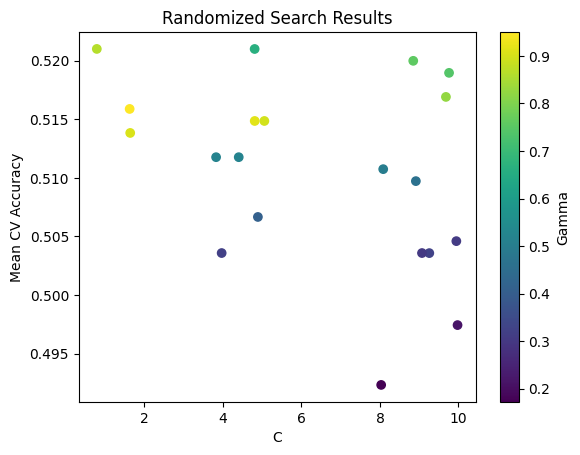

In [79]:
import matplotlib.pyplot as plt

plt.scatter(results_df['param_C'], results_df['mean_test_score'], c=results_df['param_gamma'], cmap='viridis')
plt.colorbar(label='Gamma')
plt.xlabel('C')
plt.ylabel('Mean CV Accuracy')
plt.title('Randomized Search Results')
plt.show()

Best hyperparameters are
C=0.7858
gamma = 0.8624

what does it mean?
Hyperparameter C is on the higher side, which means tolerance of misclassification is low. This gives more penalty to misclassification.
Gamma of 0.8624 means tight decision boundaries and sensitive to individual data points, high gamma kernel decays quickly thus risk of overfitting rises.

In [83]:
# Tuned hyperparameters
svm_model_tuned = SVC(kernel='rbf', C=0.7858, gamma=0.8624, probability=True, random_state=42)


In [84]:

svm_model_tuned.fit(X_train, y_train)


SVC(C=0.7858, gamma=0.8624, probability=True, random_state=42)

In [87]:
# Predict on test set
y_pred_tuned = svm_model_tuned.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))

# Detailed report
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))

Accuracy: 0.5591836734693878
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.02      0.04       107
           1       0.56      0.98      0.71       138

    accuracy                           0.56       245
   macro avg       0.48      0.50      0.38       245
weighted avg       0.49      0.56      0.42       245

Confusion Matrix:
 [[  2 105]
 [  3 135]]


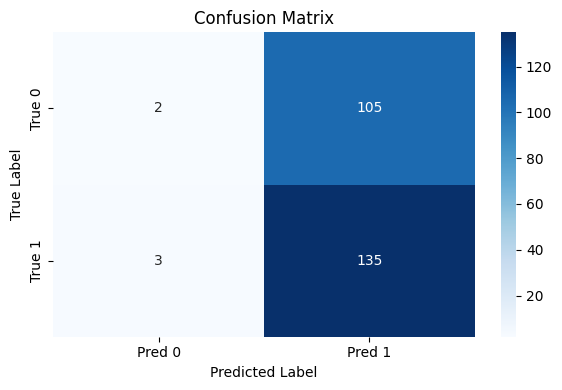

In [88]:
#Visulalisation of confusion matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_tuned)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


This result is worst than gamma=0.1, because tight decision boundary might have caused overfitting

Let us try and manually tune gamma

In [115]:
results = []

gammas_to_try = [0.001, 0.01, 0.1, 0.5, 1, 2]

for gamma in gammas_to_try:
    model = SVC(C=0.7858, gamma=gamma, kernel='rbf', class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred_gamma = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred_gamma)
    cm = confusion_matrix(y_test, y_pred_gamma)
    report = classification_report(y_test, y_pred_gamma, output_dict=True)

    results.append({
        'gamma': gamma,
        'accuracy': acc,
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'confusion_matrix': cm
    })

In [117]:
df_results = pd.DataFrame(results)
best_gamma = df_results.sort_values(by='accuracy', ascending=False).iloc[0]
print("Best gamma based on accuracy:")
print(best_gamma)

Best gamma based on accuracy:
gamma                                1.0
accuracy                        0.571429
precision_0                          0.6
recall_0                        0.056075
f1_0                            0.102564
precision_1                     0.570213
recall_1                        0.971014
f1_1                            0.718499
confusion_matrix    [[6, 101], [4, 134]]
Name: 4, dtype: object


In each case SVM is predicting more 'up' days than actually are, this can happen because of following:
1. Class imbalance: which has been taken care by using class_weight="balanced"
2. High gamma: even using low gamma values there is not much change in accuracy and precision.
3. Regime change: Strong signs of regime change (as data ranges from 2020 to 2021 evident effect of covid-19 pandemic)

Since, point 1 and 2 has been taken care of we see SVM classification can be deeply affected by regime changes in the financial markets